In [1]:
import numpy as np

import time

import warnings
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor as NestablePool

import dill
from tqdm.notebook import tqdm

from copy import deepcopy

In [2]:
from experimental_setup import *

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


# Uniform sampling

In [3]:
args, args_idx = get_uniform_args()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    parallel = True
    if parallel:
        with NestablePool(int(n_parallel/n_chains)) as p:
            uniform_arr = p.map(uniform_sampling_single_arg, args)
    else:
        uniform_arr = []
        for arg in args:
            uniform_arr.append(uniform_sampling(*arg))

prior = {args_idx[i]: _states for i, _states in enumerate(uniform_arr)}

with open("data/prior", "wb") as fhandle:
    dill.dump(prior, fhandle)

# Posterior sampling

In [4]:
with open("data/prior", "rb") as fhandle:
    prior = dill.load(fhandle)
    
args, args_idx = get_posterior_args()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    parallel = True
    if parallel:
        with NestablePool(int(n_parallel/n_chains)) as p:
            posterior_arr = p.map(posterior_sampling_single_arg, args)
    else:
        posterior_arr = []
        for arg in args:
            posterior_arr.append(posterior_sampling(*arg))

posterior_states = {args_idx[i]: _states for i, _states in enumerate(posterior_arr)}

with open("data/posterior", "wb") as fhandle:
    dill.dump(posterior_states, fhandle)

# Bruteforce sampling

In [3]:
with open("data/prior", "rb") as fhandle:
    prior = dill.load(fhandle)
    
args, args_idx = get_bruteforce_args(prior)
print(len(args))

13085


In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    parallel = True
    if parallel:
        with Pool(n_parallel) as p:
            bruteforce_arr = p.starmap(bruteforce_sampling, args)
    else:
        bruteforce_arr = []
        for arg in args:
            bruteforce_arr.append(bruteforce_sampling(*arg))

    with open("data/bruteforce_raw", "wb") as fhandle:
        dill.dump(bruteforce_arr, fhandle)
    #    !git add data/* && git commit -m "bruteforce run"

## Data aggregation

In [10]:
with open("data/bruteforce_raw", "rb") as fhandle:
    data_arr = dill.load(fhandle)
    
print(len(data_arr))
    
results = {(problem, proposal): None for problem in problems for proposal in proposals}

for i, (problem, proposal, j, seed) in enumerate(args_idx):
    shape = (len(targets), len(stepsize_grids[(problem, proposal)]), n_seeds, n_chains)
    if results[(problem, proposal)] is None:
        results[(problem, proposal)] = np.zeros(shape)

    results[(problem, proposal)][:, j, seed] = np.array(data_arr[i])
        
with open("data/bruteforce_data", "wb") as fhandle:
    dill.dump(results, fhandle)
#    !git add data/*_time_gps && git commit -m "added time-per-sample posterior gps"

13085


In [11]:
def kernel(x, y, l = 1, sigma = 1):
    sqdist = np.sum(x**2, 1).reshape(-1, 1) + np.sum(y**2, 1) - 2 * np.dot(x, y.T)
    return sigma**2 * np.exp(-0.5 / l**2 * sqdist)
  
def posterior(x, x_obs, y_obs, l = 1, sigma_f = 1, sigma_y = 0, prior_mu = 0):
    K = kernel(x_obs, x_obs, l, sigma_f) + sigma_y * np.eye(len(x_obs))
    K_s = kernel(x_obs, x, l, sigma_f)
    K_ss = kernel(x, x, l, sigma_f)
    K_inv = np.linalg.inv(K)

    mu = prior_mu + K_s.T.dot(K_inv).dot(y_obs - prior_mu)
    cov = K_ss - K_s.T.dot(K_inv).dot(K_s) #+ sigma_y * np.eye(len(x))

    return mu, cov

gps = dict()

N = 200

shape = (N, 2)
gps = {(problem, proposal): np.zeros(shape) for problem in problems for proposal in proposals}
        
for i, problem in enumerate(problems):
    for j, proposal in enumerate(proposals):
        target = "t"
        target_idx = list(targets).index(target)
        
        stepsize_grid = stepsize_grids[(problem, proposal)]

        y = results[(problem, proposal)][target_idx].reshape(len(stepsize_grid), -1)
        y_mean = np.mean(y, axis=-1) 

        y /= np.max(y_mean)
        y_mean /= np.max(y_mean)

        X, Y = np.array([np.log10(stepsize_grid)]*y.shape[-1]).T.flatten().reshape(-1, 1), y.flatten().reshape(-1, 1)

        _x = np.linspace(-5, 3, N).reshape(-1, 1)
        mu, cov = posterior(_x, X, Y, sigma_y=.1, l=2)
        gps[(problem, proposal)][:, 0] = mu.flatten()
        gps[(problem, proposal)][:, 1] = np.sqrt(np.diag(cov)).flatten()

with open("data/time_gps", "wb") as fhandle:
    dill.dump(gps, fhandle)

# Tuning

In [ ]:
args, args_idx = get_tuning_args()
print(len(args))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    parallel = True
    if parallel:
        with Pool(n_parallel) as p:
            tuning_arr = p.starmap(tuning, args)
    else:
        tuning_arr = []
        for arg in args:
            tuning_arr.append(tuning(*arg))
     
    with open("data/tuning_raw", "wb") as fhandle:
        dill.dump(tuning_arr, fhandle)
    #    !git add data/* && git commit -m "bruteforce run"       

In [ ]:
with open("data/tuning_raw", "rb") as fhandle:
    tuning_arr = dill.load(fhandle)
    
_data = {args_idx[i]: (stepsize, data) for i, (time, stepsize, convergence, data) in enumerate(tuning_arr)}

results = {}
gridsize = ts_params["grid_size"]

for problem in problems:
    for proposal in proposals:
        #results[(problem, proposal)] = {}
        _results = {}

        for target in tuning_targets:
            _results[target] = ([], [], [], [])
            for seed in range(n_seeds):
                stepsize, data = _data[(problem, proposal, target, seed)]
                _results[target][0].append(stepsize)
                _results[target][1].append(data[:,1])
                _results[target][2].append(data[:,2])
                idx = np.where(np.sum(data[:,3:], axis=1) != 0)
                _results[target][3].append(data[idx,3:][0])
                
        results[(problem, proposal)] = _results
    
with open("data/tuning_data", "wb") as fhandle:
    dill.dump(results, fhandle)

# Pure Tuning

In [ ]:
args, args_idx = get_pure_tuning_args()
print(len(args))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    parallel = True
    if parallel:
        with Pool(n_parallel) as p:
            tuning_arr = p.starmap(tuning, args)
    else:
        tuning_arr = []
        for arg in args:
            tuning_arr.append(tuning(*arg))
     
    with open("data/pure_tuning_raw", "wb") as fhandle:
        dill.dump(tuning_arr, fhandle)
    #    !git add data/* && git commit -m "bruteforce run"       

420


In [4]:
with open("data/pure_tuning_raw", "rb") as fhandle:
    tuning_arr = dill.load(fhandle)
    
_data = {args_idx[i]: (stepsize, data) for i, (time, stepsize, convergence, data) in enumerate(tuning_arr)}

results = {}
gridsize = ts_params["grid_size"]

for problem in tuning_problems:
    for proposal in proposals:
        if proposal == 'CSmMALA': continue
        #results[(problem, proposal)] = {}
        _results = {}

        for target in tuning_targets:
            _results[target] = ([], [], [], [])
            for seed in range(n_seeds):
                stepsize, data = _data[(problem, proposal, target, seed)]
                _results[target][0].append(stepsize)
                _results[target][1].append(data[:,1])
                _results[target][2].append(data[:,2])
                idx = np.where(np.sum(data[:,3:], axis=1) != 0)
                _results[target][3].append(data[idx,3:][0])
                
        results[(problem, proposal)] = _results
    
with open("data/pure_tuning_data", "wb") as fhandle:
    dill.dump(results, fhandle)

ValueError: not enough values to unpack (expected 4, got 3)

ERROR! Session/line number was not unique in database. History logging moved to new session 79


# Validation Priors

In [3]:
args, args_idx = get_uniform_args(tuning_problems)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    parallel = True
    if parallel:
        with NestablePool(int(n_parallel/n_chains)) as p:
            uniform_arr = p.map(uniform_sampling_single_arg, args)
    else:
        uniform_arr = []
        for arg in args:
            uniform_arr.append(uniform_sampling(*arg))

prior = {args_idx[i]: _states for i, _states in enumerate(uniform_arr)}

with open("data/validation_prior", "wb") as fhandle:
    dill.dump(prior, fhandle)

In [4]:
print("abc")

abc


# Simplicus Sampling

In [43]:
simpl = x3c.X3CModel("models/Simplicus.fml")
uniform_problem = hopsy.Problem(simpl.A, simpl.b, None, simpl.initial_point)
simpl_problem = hopsy.Problem(simpl.A, simpl.b, simpl, simpl.initial_point)

mcs = [hopsy.MarkovChain(uniform_problem, hopsy.UniformCoordinateHitAndRunProposal) for i in range(10)]
rngs = [hopsy.RandomNumberGenerator(0, i) for i in range(10)]

accrate, prior = hopsy.sample(mcs, rngs, 1000, 1, n_threads=10)

In [37]:
mcs = [hopsy.MarkovChain(simpl_problem, hopsy.CSmMALAProposal) for i in range(10)]
rngs = [hopsy.RandomNumberGenerator(0, i) for i in range(10)]

accrate, posterior = hopsy.sample(mcs, rngs, 1000, 10, n_threads=10)

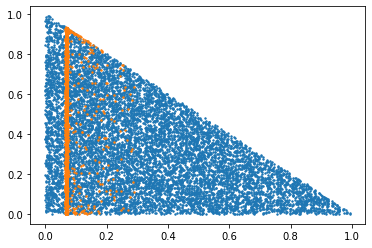

In [44]:
plt.scatter(prior[:,:,0], prior[:,:,1], s=2)
plt.scatter(posterior[:,:,0], posterior[:,:,1], s=2)

with open("data/simplicus", "wb") as fhandle:
    dill.dump((simpl.parameter_names, {'Simplicus': prior}, {'Simplicus': posterior}), fhandle)

In [10]:
model = x3c.X3CModel("models/Coryne.fml")
hopsy.Problem(model.A, model.b, model)

hopsy.Problem(A=array([[ 0.00000000e+00, -1.11864275e+02, -5.46970185e+02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.11864275e+02,  5.46970185e+02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.70749862e-02, -8.34896427e-02,
         1.82073475e-02,  7.67572971e-02, -6.87059221e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.49999995e+05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.97022787e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.